In [1]:
%reset -f

## Imports libs

In [2]:
import sys
import os
import cv2
import numpy as np
import paddle
import math
import time
import collections
import tarfile
import urllib.request
import copy


from PIL import Image
from pathlib import Path
from openvino.runtime import Core
from IPython import display
from tqdm import tqdm

import pre_post_processing as processing
import pandas as pd
import scipy as sp

## the function to download pre-trained txt-det/rec models
## Prameters
- model_url: url link to pre-trained models
- model_file_path: file path to store the downloaded model

In [3]:
def run_model_download(model_url, model_file_path):
    
    model_name = model_url.split("/")[-1]
    
    if model_file_path.is_file(): 
        print("Downloaded already")
    else:
        
        print("Downloading")

        # Create a directory.
        os.makedirs("model", exist_ok=True)
        urllib.request.urlretrieve(model_url, f"model/{model_name} ")
        print("Downloaded")

        file = tarfile.open(f"model/{model_name} ")
        res = file.extractall("model")
        file.close()
        if not res:
            print(f"Extracted to {model_file_path}.")
        else:
            print("Check the network.")

## Now download the txt-det model

In [4]:
det_model_url = "https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar"
det_model_file_path = Path("model/en_PP-OCRv3_det_infer/inference.pdmodel")

run_model_download(det_model_url, det_model_file_path)

Downloaded already


## Load the txt-det model

In [5]:
core = Core()
det_model = core.read_model(model=det_model_file_path)
det_compiled_model = core.compile_model(model=det_model, device_name="CPU")

# Get input and output nodes for text detection.
det_input_layer = det_compiled_model.input(0)
det_output_layer = det_compiled_model.output(0)

## Download the txt-rec model

In [6]:
rec_model_url = "https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_infer.tar"
rec_model_file_path = Path("model/en_PP-OCRv3_rec_infer/inference.pdmodel")

run_model_download(rec_model_url, rec_model_file_path)

Downloaded already


## Load the txt-rec model into dynamic shape

In [7]:
# Read the model and corresponding weights from a file.
rec_model = core.read_model(model=rec_model_file_path)

# Assign dynamic shapes to every input layer on the last dimension.
for input_layer in rec_model.inputs:
    input_shape = input_layer.partial_shape
    input_shape[3] = -1
    rec_model.reshape({input_layer: input_shape})

rec_compiled_model = core.compile_model(model=rec_model, device_name="CPU")

# Get input and output nodes.
rec_input_layer = rec_compiled_model.input(0)
rec_output_layer = rec_compiled_model.output(0)

## Function to preprocessing input image for txt-det

## Parameters:
- input_image: input image 
- size: value for the image to be resized for text detection model

In [8]:
# det
def image_preprocess(input_image, size):
    
    img = cv2.resize(input_image, (size, size))
    img = np.transpose(img, [2, 0, 1]) / 255
    img = np.expand_dims(img, 0)
    # NormalizeImage: {mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225], is_scale: True}
    img_mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    img_std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    img -= img_mean
    img /= img_std
    return img.astype(np.float32)

## Function to resize input image for txt-rec

## Parameters:
- img: bounding box image from text detection 
- max_wh_ratio: value for the resizing for text recognition model

In [9]:
# Preprocess for text recognition.
def resize_norm_img(img, max_wh_ratio):
    
    
    rec_image_shape = [3, 48, 320]
    imgC, imgH, imgW = rec_image_shape
    assert imgC == img.shape[2]
    character_type = "digits"
    if character_type == "cn":
        imgW = int((32 * max_wh_ratio))
    h, w = img.shape[:2]
    ratio = w / float(h)
    if math.ceil(imgH * ratio) > imgW:
        resized_w = imgW
    else:
        resized_w = int(math.ceil(imgH * ratio))
    resized_image = cv2.resize(img, (resized_w, imgH))
    resized_image = resized_image.astype('float32')
    resized_image = resized_image.transpose((2, 0, 1)) / 255
    resized_image -= 0.5
    resized_image /= 0.5
    padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
    padding_im[:, :, 0:resized_w] = resized_image
    return padding_im

## Function to preprocessing of the detected bounding boxes for txt-rec

## Parameters:
- dt_boxes: detected bounding boxes from text detection 
- frame: original input frame 


In [10]:
def prep_for_rec(dt_boxes, frame):
    
    ori_im = frame.copy()
    img_crop_list = [] 
    for bno in range(len(dt_boxes)):
        tmp_box = copy.deepcopy(dt_boxes[bno])
        img_crop = processing.get_rotate_crop_image(ori_im, tmp_box)
        img_crop_list.append(img_crop)
        
    img_num = len(img_crop_list)
    # Calculate the aspect ratio of all text bars.
    width_list = []
    for img in img_crop_list:
        width_list.append(img.shape[1] / float(img.shape[0]))
    
    # Sorting can speed up the recognition process.
    indices = np.argsort(np.array(width_list))
    return img_crop_list, img_num, indices

## Function to batch for txt-rec

## Parameters:
- img_crop_list: processed detected bounding box images 
- img_num: number of bounding boxes from text detection
- indices: sorting for bounding boxes to speed up text recognition
- beg_img_no: the beginning number of bounding boxes for each batch of text recognition inference
- batch_num: number of images for each batch


In [11]:
def batch_text_box(img_crop_list, img_num, indices, beg_img_no, batch_num):

    norm_img_batch = []
    max_wh_ratio = 0
    end_img_no = min(img_num, beg_img_no + batch_num)
    for ino in range(beg_img_no, end_img_no):
        h, w = img_crop_list[indices[ino]].shape[0:2]
        wh_ratio = w * 1.0 / h
        max_wh_ratio = max(max_wh_ratio, wh_ratio)
    for ino in range(beg_img_no, end_img_no):
        norm_img = resize_norm_img(img_crop_list[indices[ino]], max_wh_ratio)
        norm_img = norm_img[np.newaxis, :]
        norm_img_batch.append(norm_img)

    norm_img_batch = np.concatenate(norm_img_batch)
    norm_img_batch = norm_img_batch.copy()
    return norm_img_batch

## Function to postprocess the results from text detection into bounding boxes

## Parameters:
- frame: input image 
- det_results: inference results from text detection model

In [12]:
def post_processing_detection(frame, det_results):

    ori_im = frame.copy()
    data = {'image': frame}
    data_resize = processing.DetResizeForTest(data)
    data_list = []
    keep_keys = ['image', 'shape']
    for key in keep_keys:
        data_list.append(data_resize[key])
    img, shape_list = data_list

    shape_list = np.expand_dims(shape_list, axis=0) 
    pred = det_results[0]    
    if isinstance(pred, paddle.Tensor):
        pred = pred.numpy()
    segmentation = pred > 0.3

    boxes_batch = []
    for batch_index in range(pred.shape[0]):
        src_h, src_w, ratio_h, ratio_w = shape_list[batch_index]
        mask = segmentation[batch_index]
        boxes, scores = processing.boxes_from_bitmap(pred[batch_index], mask, src_w, src_h)
        boxes_batch.append({'points': boxes})
    post_result = boxes_batch
    dt_boxes = post_result[0]['points']
    dt_boxes = processing.filter_tag_det_res(dt_boxes, ori_im.shape)    
    return dt_boxes

## The image OCR function

In [13]:
def run_paddle_ocr(source, show_result=True):
    
    global out
    
    # Grab the image.
    image = cv2.imread(source)

    # If the image is larger than full HD, reduce size to improve the performance.
    scale = 1280 / max(image.shape)
    if scale < 1:
        image = cv2.resize(src=image, dsize=None, fx=scale, fy=scale,interpolation=cv2.INTER_AREA)
    
    # Preprocess the image for text detection.
    test_image = image_preprocess(image, 640)

    # Perform the inference step.
    det_results = det_compiled_model([test_image])[det_output_layer]
    
    # Postprocessing for Paddle Detection.
    dt_boxes = post_processing_detection(image, det_results)

    # Preprocess detection results for recognition.
    dt_boxes = processing.sorted_boxes(dt_boxes)  
    batch_num = 16
    img_crop_list, img_num, indices = prep_for_rec(dt_boxes, image)
    
    # For storing recognition results, include two parts:
    # txts are the recognized text results, scores are the recognition confidence level. 

    for beg_img_no in range(0, img_num, batch_num):

        # Recognition starts from here.
        norm_img_batch = batch_text_box(img_crop_list, img_num, indices, beg_img_no, batch_num)

        # Run inference for text recognition. 
        rec_results = rec_compiled_model([norm_img_batch])[rec_output_layer]
        
        # Postprocessing recognition results.
        postprocess_op = processing.build_post_process(processing.postprocess_params)
        out = postprocess_op(rec_results)[0]
        
    if show_result:   
        print('the file is ', source)
        print('the carid is ', out[0])
        print('the conf level is ', out[1])
        
    return [out[0], out[1], source]


## Run OCR with a video steam (transformed into jpg using opencv).

In [14]:
def OCR_inf(path_tmp):
    
    print('')
    print('inference folder : ', path_tmp)

    mylist = os.listdir(path_tmp)
    mylist = sorted(mylist)

    # OCR inference starts in the current folder
    carid = []
    conf  = []
    fpath = []

    for file_name in tqdm(mylist):
        file_path = path_tmp + '/' + file_name
        tmp_result = run_paddle_ocr(source=file_path, show_result=False)

        carid.append(tmp_result[0])
        conf.append(tmp_result[1])
        fpath.append(tmp_result[2][47:][:-4])        

    #save the inference result as a df
    df = pd.DataFrame(list(zip(carid, conf)), columns =['carid', 'conf'])

    #drop any inference result with id longer than 5, shorted than 4, or less certain than 0.95
    df['len_id'] = df.carid.str.len()
    df = df[ ( (df.len_id == 4) | (df.len_id == 5) ) & (df.conf > 0.95)]
    df = df.drop(['len_id'], axis=1)

    #list all the possible id
    pot_id_int = sorted( df.carid.unique(), key=len)
    pot_id = [str(x) for x in pot_id_int]
    print("all the possible carid are ", pot_id)

    #set the longest carid as full
    full = pot_id[-1]

    #define the function to remove ith cha from a string
    def remove(string, i):
        if i > len(string):
            return string
        a = list(string)
        a.pop(i)
        return "".join(a)

    #check if the short id is missing one digit from full
    for i in range(len(pot_id)-1):

        ctr = [full.find(pot_id[i])] 

        for j in range(len(full)):
            tmp = (remove(full,j)).find(pot_id[i])
            ctr.append(tmp)

        if any(ctr) >= 0:
            pot_id.remove(pot_id[i]) 

    #if ids are completely different
    if len(pot_id) > 1:

        df1 = df.groupby(['carid']).max()
        pot_id = df1[df1.conf == df1.conf.max()].index[0]

    print('the final carid is ', pot_id)
    print('')

In [15]:
!rm -rf '/home/ning/Downloads/openvino_paddle/test/.ipynb_checkpoints'

# folder path
dir_path = '/home/ning/Downloads/openvino_paddle/test/'

# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)) != True:
        res.append(dir_path + path);
# include all the frame names
path_tmp = sorted(res)

path_tmp

['/home/ning/Downloads/openvino_paddle/test/10169',
 '/home/ning/Downloads/openvino_paddle/test/10402',
 '/home/ning/Downloads/openvino_paddle/test/2632',
 '/home/ning/Downloads/openvino_paddle/test/2737',
 '/home/ning/Downloads/openvino_paddle/test/3102',
 '/home/ning/Downloads/openvino_paddle/test/3216',
 '/home/ning/Downloads/openvino_paddle/test/3268',
 '/home/ning/Downloads/openvino_paddle/test/5371',
 '/home/ning/Downloads/openvino_paddle/test/5956',
 '/home/ning/Downloads/openvino_paddle/test/7060',
 '/home/ning/Downloads/openvino_paddle/test/7263',
 '/home/ning/Downloads/openvino_paddle/test/7305',
 '/home/ning/Downloads/openvino_paddle/test/7409',
 '/home/ning/Downloads/openvino_paddle/test/7656',
 '/home/ning/Downloads/openvino_paddle/test/7758',
 '/home/ning/Downloads/openvino_paddle/test/9678',
 '/home/ning/Downloads/openvino_paddle/test/9979']

In [17]:
for i in range(len(path_tmp)):
    OCR_inf(path_tmp[i])


inference folder :  /home/ning/Downloads/openvino_paddle/test/10169


100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.99it/s]


all the possible carid are  ['10169']
the final carid is  ['10169']


inference folder :  /home/ning/Downloads/openvino_paddle/test/10402


100%|█████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.82it/s]


all the possible carid are  ['0402', '10402']
the final carid is  ['10402']


inference folder :  /home/ning/Downloads/openvino_paddle/test/2632


100%|███████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 22.47it/s]


all the possible carid are  ['2632']
the final carid is  ['2632']


inference folder :  /home/ning/Downloads/openvino_paddle/test/2737


100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 22.58it/s]


all the possible carid are  ['2737']
the final carid is  ['2737']


inference folder :  /home/ning/Downloads/openvino_paddle/test/3102


100%|█████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.45it/s]


all the possible carid are  ['3102']
the final carid is  ['3102']


inference folder :  /home/ning/Downloads/openvino_paddle/test/3216


100%|█████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 22.43it/s]


all the possible carid are  ['3216']
the final carid is  ['3216']


inference folder :  /home/ning/Downloads/openvino_paddle/test/3268


100%|█████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 22.55it/s]


all the possible carid are  ['3268']
the final carid is  ['3268']


inference folder :  /home/ning/Downloads/openvino_paddle/test/5371


100%|█████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.57it/s]


all the possible carid are  ['5371']
the final carid is  ['5371']


inference folder :  /home/ning/Downloads/openvino_paddle/test/5956


100%|█████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.54it/s]


all the possible carid are  ['5956']
the final carid is  ['5956']


inference folder :  /home/ning/Downloads/openvino_paddle/test/7060


100%|█████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24.19it/s]


all the possible carid are  ['5956', '7060']
the final carid is  ['7060']


inference folder :  /home/ning/Downloads/openvino_paddle/test/7263


100%|█████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 22.43it/s]


all the possible carid are  ['7263']
the final carid is  ['7263']


inference folder :  /home/ning/Downloads/openvino_paddle/test/7305


100%|█████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.30it/s]


all the possible carid are  ['7263', '7305']
the final carid is  ['7305']


inference folder :  /home/ning/Downloads/openvino_paddle/test/7409


100%|█████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.45it/s]


all the possible carid are  ['7409']
the final carid is  ['7409']


inference folder :  /home/ning/Downloads/openvino_paddle/test/7656


100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 22.70it/s]


all the possible carid are  ['7656']
the final carid is  ['7656']


inference folder :  /home/ning/Downloads/openvino_paddle/test/7758


100%|█████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 22.50it/s]


all the possible carid are  ['7758']
the final carid is  ['7758']


inference folder :  /home/ning/Downloads/openvino_paddle/test/9678


100%|███████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.69it/s]


all the possible carid are  ['9768']
the final carid is  ['9768']


inference folder :  /home/ning/Downloads/openvino_paddle/test/9979


100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 22.31it/s]

all the possible carid are  ['9979']
the final carid is  ['9979']



## Main function to run the paddleOCR inference:

- Create a video player to play with target fps (utils.VideoPlayer).
- Prepare a set of frames for text detection and recognition.
- Run AI inference for both text detection and recognition.
- Visualize the results.

## Parameters:
- source: The webcam number to feed the video stream with primary webcam set to "0", or the video path.  
- flip: To be used by VideoPlayer function for flipping capture image.
- use_popup: False for showing encoded frames over this notebook, True for creating a popup window.
- skip_first_frames: Number of frames to skip at the beginning of the video. 

In [18]:
sys.path.append("../utils")
import notebook_utils as utils

def wecam_ocr(source=0, flip=False, use_popup=False, skip_first_frames=0):

    # Create a video player to play with target fps.
    player = None
    try:
        player = utils.VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start video capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(src=frame, dsize=None, fx=scale, fy=scale,
                                   interpolation=cv2.INTER_AREA)
            # Preprocess the image for text detection.
            test_image = image_preprocess(frame, 640)
                
            # Measure processing time for text detection.
            start_time = time.time()
            # Perform the inference step.
            det_results = det_compiled_model([test_image])[det_output_layer]
            stop_time = time.time()

            # Postprocessing for Paddle Detection.
            dt_boxes = post_processing_detection(frame, det_results)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()
            processing_time_det = np.mean(processing_times) * 1000

            # Preprocess detection results for recognition.
            dt_boxes = processing.sorted_boxes(dt_boxes)  
            batch_num = 6
            img_crop_list, img_num, indices = prep_for_rec(dt_boxes, frame)
            
            # For storing recognition results, include two parts:
            # txts are the recognized text results, scores are the recognition confidence level. 
            rec_res = [['', 0.0]] * img_num
            txts = [] 
            scores = []

            for beg_img_no in range(0, img_num, batch_num):

                # Recognition starts from here.
                norm_img_batch = batch_text_box(
                    img_crop_list, img_num, indices, beg_img_no, batch_num)

                # Run inference for text recognition. 
                rec_results = rec_compiled_model([norm_img_batch])[rec_output_layer]

                # Postprocessing recognition results.
                postprocess_op = processing.build_post_process(processing.postprocess_params)
                rec_result = postprocess_op(rec_results)
                for rno in range(len(rec_result)):
                    rec_res[indices[beg_img_no + rno]] = rec_result[rno]   
                if rec_res:
                    txts = [rec_res[i][0] for i in range(len(rec_res))] 
                    scores = [rec_res[i][1] for i in range(len(rec_res))]
                                   
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            boxes = dt_boxes
            # Draw text recognition results beside the image.
            draw_img = processing.draw_ocr_box_txt(
                image,
                boxes,
                txts,
                scores,
                drop_score=0.5)

            # Visualize the PaddleOCR results.
            f_height, f_width = draw_img.shape[:2]
            fps = 1000 / processing_time_det
            cv2.putText(img=draw_img, text=f"Inference time: {processing_time_det:.1f}ms ({fps:.1f} FPS)", 
                        org=(20, 40),fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=f_width / 1000,
                        color=(0, 0, 255), thickness=1, lineType=cv2.LINE_AA)
            
            # Use this workaround if there is flickering.
            if use_popup: 
                draw_img = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
                cv2.imshow(winname=title, mat=draw_img)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                draw_img = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
                _, encoded_img = cv2.imencode(ext=".jpg", img=draw_img,
                                              params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
            
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

## webcam ocr for txt and recognize digits only

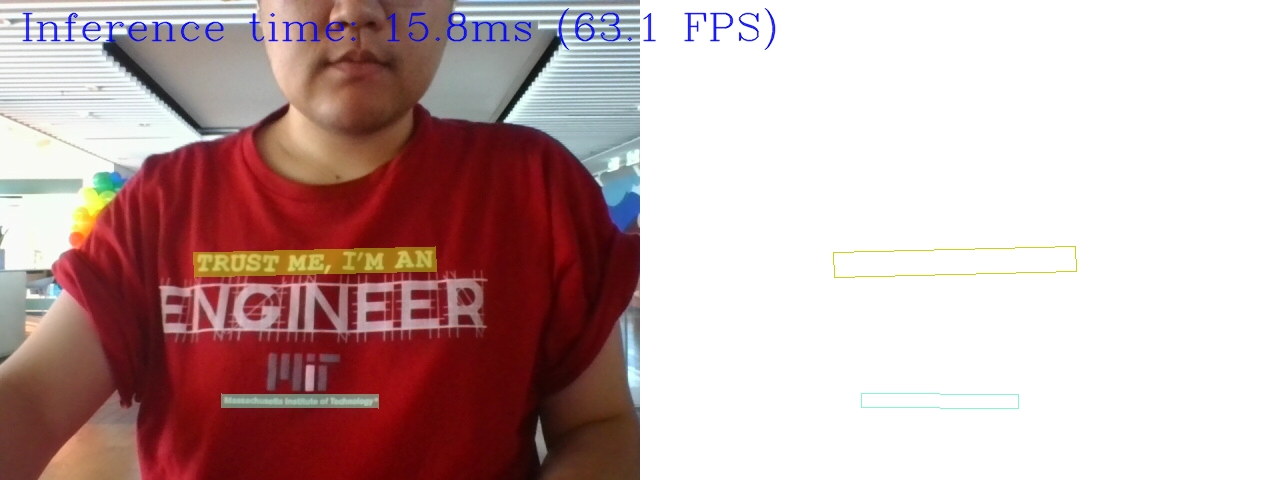

Interrupted


In [19]:
wecam_ocr(source=0, flip=False, use_popup=False)